# CXR 이미지로 COVID19 분류

### DensNet

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 폴더 이동
%cd drive/My\ Drive/ai-school/CXR-pjt
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ai-school/CXR-pjt
/content/drive/My Drive/ai-school/CXR-pjt


In [2]:
# 라이브러리
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet201
from tqdm import tqdm
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
import glob as gb
import cv2
import os

In [3]:
# 하이퍼파라미터
epochs = 50
image_size = 224

LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

In [4]:
# path 설정 
path_train = "./Data/train/"
path_test = "./Data/test/"

path_train_PNEUMONIA = path_train + "PNEUMONIA/"
path_train_NORMAL = path_train + "NORMAL/"
path_train_COVID19 = path_train + "COVID19/"

In [5]:
# 확인
path_train_NORMAL

'./Data/train/NORMAL/'

In [6]:
# 이미지 확인
image = path_train_PNEUMONIA + "PNEUMONIA(1).jpg"
plt.imread(image)

array([[66, 64, 62, ..., 22, 23, 24],
       [66, 63, 61, ..., 22, 23, 23],
       [67, 64, 61, ..., 22, 22, 23],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

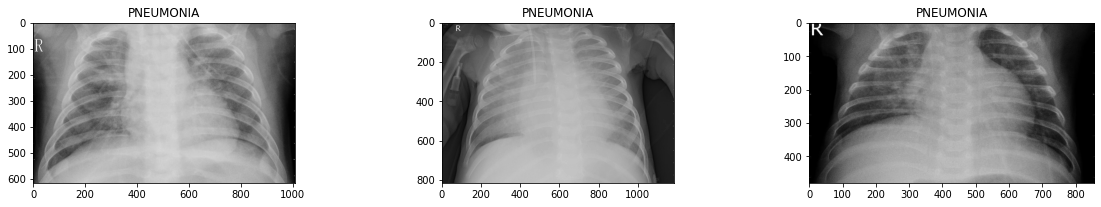

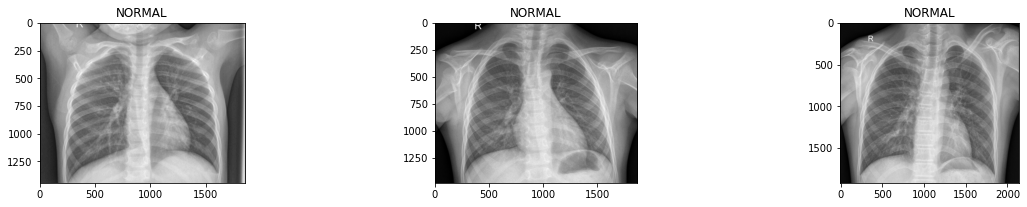

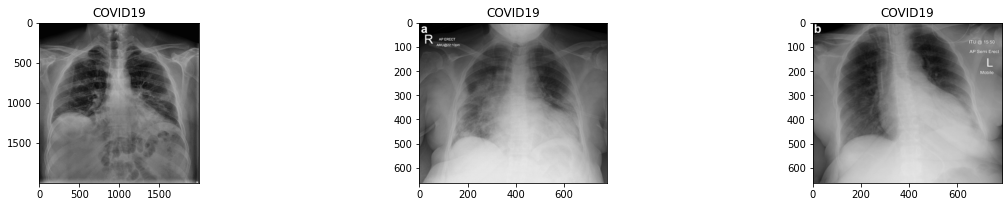

In [7]:
# 이미지 확인
plt.figure(figsize=(20,10))
for i in range(5, 8):
    plt.subplot(3, 3, i-4)
    plt.imshow(plt.imread(path_train_PNEUMONIA + f"PNEUMONIA({i}).jpg"), cmap='gray')
    plt.title("PNEUMONIA")
    

plt.figure(figsize=(20,10))
for i in range(5, 8):
    plt.subplot(3, 3, i-4)
    plt.imshow(plt.imread(path_train_NORMAL + f"NORMAL({i}).jpg"), cmap='gray')
    plt.title("NORMAL")


plt.figure(figsize=(20,10))
for i in range(5, 8):
    plt.subplot(3, 3, i-4)
    plt.imshow(plt.imread(path_train_COVID19 + f"COVID19({i}).jpg"), cmap='gray')
    plt.title("COVID19")

plt.show()

## Data load

### Data Augmentation 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

train_generator =train_datagen.flow_from_directory(
     path_train,
     batch_size=10,
     shuffle=shuffle,
     target_size=(image_size, image_size)
)

test_generator =train_datagen.flow_from_directory(
     path_test,
     batch_size= 10,
     shuffle=shuffle,
     target_size=(image_size, image_size)
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [9]:
def getCode(label):
    return LABELS[label]

def getLabel(n):
    for key, val in LABELS.items():
        if n == val:
            return key

In [10]:
trainShape=train_generator.__getitem__(0)[0].shape
testShape=test_generator.__getitem__(0)[0].shape

print("Train Shape \n",trainShape)
print("Test Shape \n",testShape)

Train Shape 
 (10, 224, 224, 3)
Test Shape 
 (10, 224, 224, 3)


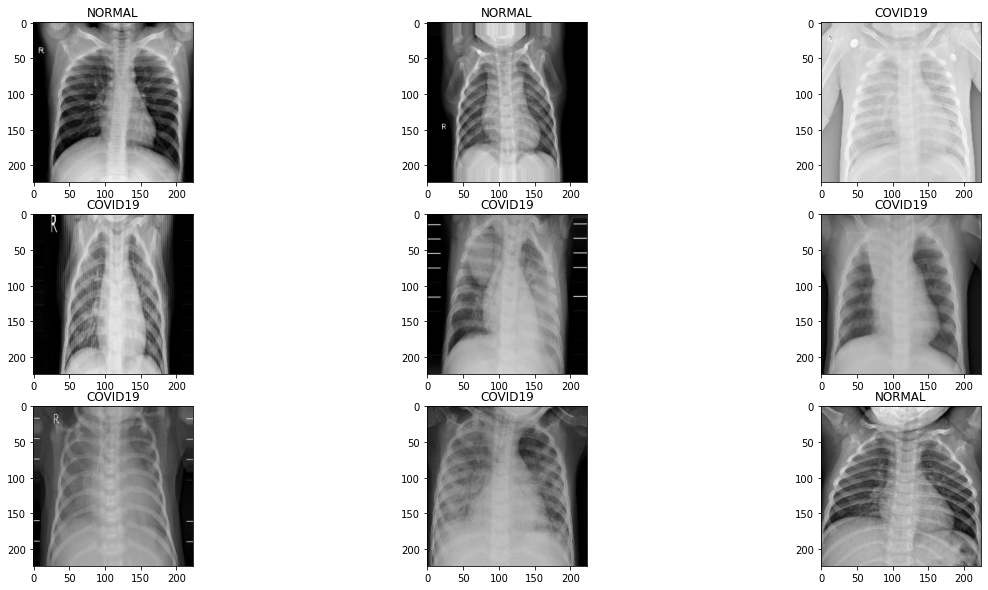

In [11]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(0)[1][i])) )
  
plt.show()

### Model

In [12]:
densenet = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

densenet.trainable = False

# densenet.summary()

In [13]:
from tensorflow.keras import Model

x = tf.keras.layers.Flatten()(densenet.output)

x = tf.keras.layers.Dense(512, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x = tf.keras.layers.Dense(3 , activation='sigmoid')(x)
       
model = Model(densenet.input, x) 

# print(model.summary())
# model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, steps_per_epoch=20, epochs=epochs)

Epoch 1/50
20/20 [==============================] - 4s 211ms/step - loss: 1.6825 - accuracy: 0.2650
Epoch 2/50
20/20 [==============================] - 5s 244ms/step - loss: 2.2377 - accuracy: 0.2850
Epoch 3/50
20/20 [==============================] - 5s 239ms/step - loss: 3.5214 - accuracy: 0.3400
Epoch 4/50
20/20 [==============================] - 5s 229ms/step - loss: 4.8389 - accuracy: 0.6950
Epoch 5/50
20/20 [==============================] - 4s 220ms/step - loss: 5.3996 - accuracy: 0.6650
Epoch 6/50
20/20 [==============================] - 5s 225ms/step - loss: 5.0782 - accuracy: 0.6850
Epoch 7/50
20/20 [==============================] - 5s 234ms/step - loss: 5.8831 - accuracy: 0.6350
Epoch 8/50
20/20 [==============================] - 4s 222ms/step - loss: 6.0443 - accuracy: 0.6250
Epoch 9/50
20/20 [==============================] - 4s 224ms/step - loss: 5.6413 - accuracy: 0.6500
Epoch 10/50
20/20 [==============================] - 5s 237ms/step - loss: 6.3666 - accuracy: 0.6050

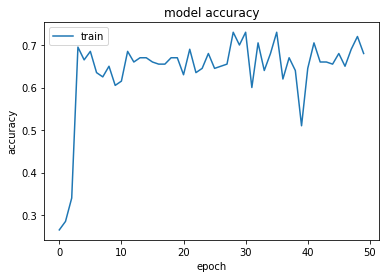

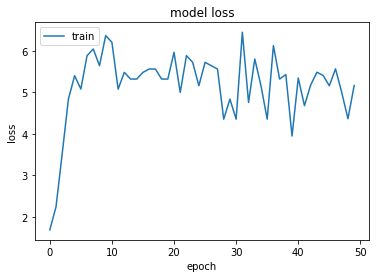

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
model.evaluate(test_generator)

# model.evaluate(test_ds, return_dict=True)

129/129 [==============================] - 32s 247ms/step - loss: 5.4186 - accuracy: 0.6638


[5.418583393096924, 0.6638198494911194]

In [17]:
# 학습된 모델 저장하기
model.save('modelCovid19_resnet.h5')

# 모델 구조를 json으로 저장하기
json_string = model.to_json()
 
with open("model.json", "w") as f : 
    f.write(json_string)

In [18]:
# 예측하기
pred = model.predict(test_generator)

In [19]:
print(len(pred))

1288


In [20]:
y_test=[]
for i in tqdm(range(128)):
    y_test.extend(test_generator.__getitem__(i)[1])

print(len(y_test))
y_test = np.array(y_test)
# print(y_test)

100%|██████████| 128/128 [00:26<00:00,  4.81it/s]

1280


In [21]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

print("pred: ",len(pred))
print("y_test: ",len(y_test))

print("y_test \n",y_test)
print("pred \n",pred)

pred:  1288
y_test:  1280
y_test 
 [2 2 0 ... 2 2 2]
pred 
 [2 2 2 ... 2 2 2]


In [22]:
from sklearn.metrics import confusion_matrix

pred = pred[:1280]
cm=confusion_matrix(pred,y_test)

print(cm)

[[  0   0   0]
 [  0   0   0]
 [116 315 849]]


In [23]:
LABELS

{'COVID19': 2, 'NORMAL': 1, 'PNEUMONIA': 0}

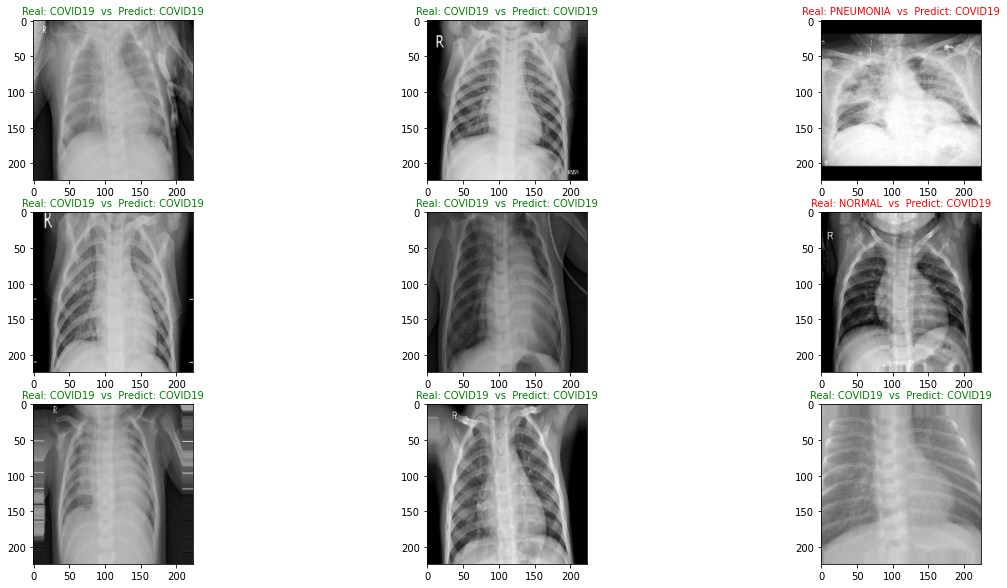

In [24]:
plt.figure(figsize=(20,10))

for i in range(0,9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_generator.__getitem__(0)[0][i], cmap='gray')

    color = "green" if y_test[i] == pred[i] else "red"
    plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(pred[i])}", color=color, fontsize=10)

In [25]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  0   0   0]
 [  0   0   0]
 [116 315 849]]


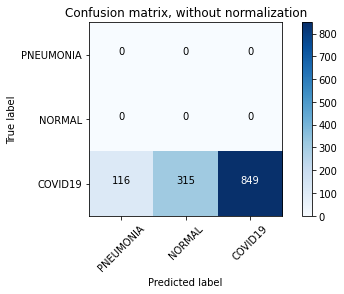

In [33]:
plt.figure()
plot_confusion_matrix(cm, classes=LABELS.keys(), title='Confusion matrix, without normalization')

## 입력 이미지를 이용해서 예측해보기

diseasePredict() 함수 구현

Text(0.5, 1.0, 'covid')

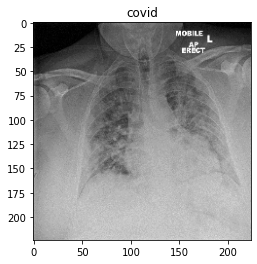

In [28]:
filename = "COVID-1.jpg"
image = f"./predict_test_img/{filename}"

image = cv2.imread(image)
image = cv2.resize(image, (image_size, image_size))

plt.imshow(image, cmap='gray')
plt.title("covid")

In [29]:
# 예측 함수
def diseasePredict(file_path, ml):
    LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    reshaped_image = image.reshape((-1, 224, 224, 3))

    pred = ml.predict(reshaped_image)
    pred_code= np.argmax(pred,axis=1)

    disease = getLabel(pred_code)

    return disease


# 예측 이미지 그리기
def showImage(file_path, ml):
    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    plt.imshow(image, cmap='gray')

    disease = diseasePredict(file_path, ml)
    plt.title(disease)
    plt.show()

In [30]:
path = "./predict_test_img/COVID-1.jpg"
ml = model

In [31]:
diseasePredict(path, ml)

'COVID19'

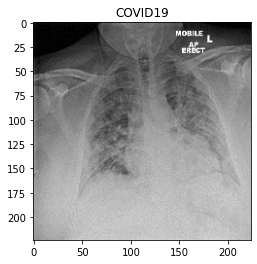

In [32]:
showImage(path, ml)